<a href="https://colab.research.google.com/github/ayesha-0610/AlmaBetter_module-task/blob/main/module6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sections: Overview, EDA, Cleaning, Feature Engineering, Modeling (>=2 models),
# Hyperparameter Tuning, Explainability, Conclusion, and Utilities for reproducibility.

# Basic data science libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:



# ---------------------------
# Helper functions
# ---------------------------


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


def evaluate(y_true, y_pred):
    return {"RMSE": rmse(y_true, y_pred), "MAE": mae(y_true, y_pred)}


def plot_series(df, col='Close', title=None, figsize=(12,4)):
    plt.figure(figsize=figsize)
    plt.plot(df.index, df[col])
    plt.title(title or f"{col} over time")
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()


def plot_actual_vs_preds(actual, preds_dict, title='Actual vs Predictions'):
    plt.figure(figsize=(12,5))
    plt.plot(actual.index, actual.values, label='Actual', linewidth=2)
    for name, p in preds_dict.items():
        plt.plot(actual.index, p, label=name, alpha=0.85)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
# 1. Load data
# ---------------------------

def load_and_parse(path='/content/data_YesBank_StockPrices.csv'):
    df = pd.read_csv(path)
    # Inspect columns
    # Date format in the provided file: 'Jul-05' -> '%b-%y'
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], format='%b-%y', errors='coerce')
        if df['Date'].isna().sum() > 0:
            # attempt more flexible parsing
            df['Date'] = pd.to_datetime(df['Date'].astype(str), infer_datetime_format=True, errors='coerce')
    else:
        # assume first column is date
        df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')

    # Sort and set index
    df = df.sort_values('Date').set_index('Date')
    return df

In [ ]:
# 2. EDA
# ---------------------------

def eda(df):
    print('Shape:', df.shape)
    print('\nColumns:\n', df.columns.tolist())
    display(df.head())

    print('\nBasic stats:')
    display(df.describe().T)

    # Missing values
    print('\nMissing values:')
    display(df.isna().sum())

    # Plot Close time series
    if 'Close' in df.columns:
        plot_series(df, 'Close', 'Close price over time')

    # Distribution
    plt.figure(figsize=(10,4))
    sns.histplot(df['Close'].dropna(), kde=True)
    plt.title('Close distribution')
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation matrix')
    plt.show()

In [ ]:
# 3. Cleaning and Outliers
# ---------------------------

def clean_and_handle(df, fill_method='ffill'):
    # Copy
    data = df.copy()
    # Missing values
    if data.isna().sum().sum() > 0:
        if fill_method == 'ffill':
            data = data.ffill().bfill()
        elif fill_method == 'drop':
            data = data.dropna()
        else:
            data = data.fillna(method='ffill').fillna(method='bfill')

    # Outliers: simple IQR capping for price columns
    price_cols = [c for c in data.columns if c.lower() in ['open','high','low','close','volume'] or data[c].dtype.kind in 'f']
    for c in price_cols:
        q1 = data[c].quantile(0.25)
        q3 = data[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        data[c] = data[c].clip(lower, upper)
    return data

In [ ]:
# 4. Feature engineering
# ---------------------------

def create_features(df):
    data = df.copy()
    # Time features
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    data['year'] = data.index.year

    # Lag features and rolling
    data['lag_1'] = data['Close'].shift(1)
    data['lag_2'] = data['Close'].shift(2)
    data['lag_12'] = data['Close'].shift(12)

    data['rolling_3'] = data['Close'].rolling(window=3).mean().shift(1)
    data['rolling_6'] = data['Close'].rolling(window=6).mean().shift(1)
    data['rolling_12'] = data['Close'].rolling(window=12).mean().shift(1)

    # Momentum
    data['pct_change_1'] = data['Close'].pct_change(1)
    data['pct_change_3'] = data['Close'].pct_change(3)

    # Difference
    data['diff_1'] = data['Close'] - data['lag_1']

    # drop NA created by shifts
    data = data.dropna()
    return data

In [ ]:
# 5. Train/Test split utility
# ---------------------------

def time_based_train_test_split(X, y, n_test=12):
    if n_test <= 0 or n_test >= len(X):
        raise ValueError('n_test must be >0 and < len(X)')
    train_X, test_X = X[:-n_test], X[-n_test:]
    train_y, test_y = y[:-n_test], y[-n_test:]
    return train_X, test_X, train_y, test_y


In [ ]:
# 6. Modeling: training & evaluation
# ---------------------------

def train_baselines(train_X, test_X, train_y, test_y):
    results = {}

    # Persistence baseline: predict previous month close
    preds_persistence = test_X['lag_1'].values
    results['Persistence'] = (preds_persistence, evaluate(test_y, preds_persistence))

    # Linear Regression
    lr = LinearRegression()
    lr.fit(train_X, train_y)
    preds_lr = lr.predict(test_X)
    results['LinearRegression'] = (preds_lr, evaluate(test_y, preds_lr))

    # RandomForest
    rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
    rf.fit(train_X, train_y)
    preds_rf = rf.predict(test_X)
    results['RandomForest'] = (preds_rf, evaluate(test_y, preds_rf), rf)

    return results

In [ ]:
# 7. Hyperparameter tuning (time-series aware)
# ---------------------------

def tune_random_forest(train_X, train_y):
    # TimeSeriesSplit for cross-val
    tscv = TimeSeriesSplit(n_splits=3)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 8, 12, None]
    }
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    gs = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    gs.fit(train_X, train_y)
    return gs

In [ ]:
# 8. Feature importance & SHAP (optional)
# ---------------------------

def plot_feature_importances(model, feature_names, top_n=15):
    if hasattr(model, 'feature_importances_'):
        fi = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(8,6))
        sns.barplot(x=fi.values[:top_n], y=fi.index[:top_n])
        plt.title('Feature Importances')
        plt.show()
    else:
        print('Model has no feature_importances_ attribute')

In [ ]:
# 9. Full pipeline runner
# ---------------------------

def run_full_pipeline(path='data_YesBank_StockPrices.csv', n_test=12, do_tune=False):
    # 1) Load
    df = load_and_parse(path)

    # 2) EDA summary
    print('\n=== EDA ===')
    eda(df)

    # 3) Cleaning
    df_clean = clean_and_handle(df, fill_method='ffill')

    # 4) Features
    data = create_features(df_clean)
    print('\nAfter feature creation, rows:', len(data))

    # 5) Prepare X/y
    feature_cols = [c for c in data.columns if c not in ['Open','High','Low','Close'] or c in ['lag_1','lag_2','lag_12','rolling_3','rolling_6','rolling_12','pct_change_1','pct_change_3','diff_1']]
    # Ensure Close excluded from features
    feature_cols = [c for c in data.columns if c != 'Close' and c in ['lag_1','lag_2','lag_12','rolling_3','rolling_6','rolling_12','pct_change_1','pct_change_3','diff_1','month','quarter','year']]
    X = data[feature_cols]
    y = data['Close']

    # 6) Split
    train_X, test_X, train_y, test_y = time_based_train_test_split(X, y, n_test=n_test)
    print('Train/Test sizes:', len(train_X), len(test_X))

    # 7) Optionally scale (trees don't need scaling but LR does). We'll scale for LR via pipeline when needed.

    # 8) Train baselines
    results = train_baselines(train_X, test_X, train_y, test_y)

    # Print results
    print('\n=== Baseline Results ===')
    for name, info in results.items():
        if name == 'RandomForest':
            preds, metrics, model = info
        else:
            preds, metrics = info
        print(f"{name}: RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}")

    # 9) Plot predictions
    preds_dict = {k: v[0] for k,v in results.items()}
    plot_actual_vs_preds(test_y, preds_dict, title='Test period - Actual vs Predictions')

    # 10) Hyperparameter tuning if requested
    if do_tune:
        print('\nRunning hyperparameter tuning (this may take a while) ...')
        gs = tune_random_forest(train_X, train_y)
        print('Best params:', gs.best_params_)
        best_rf = gs.best_estimator_
        preds_tuned = best_rf.predict(test_X)
        print('Tuned RF metrics:', evaluate(test_y, preds_tuned))
        plot_feature_importances(best_rf, train_X.columns)
    else:
        # Plot feature importances for RF trained earlier
        rf_model = results['RandomForest'][2]
        plot_feature_importances(rf_model, train_X.columns)

    # 11) Directional accuracy (useful in finance)
    def direction_accuracy(y_true, y_pred):
        true_dir = np.sign(np.diff(y_true))
        pred_dir = np.sign(np.diff(y_pred))
        return (true_dir == pred_dir).mean()

    print('\nDirectional accuracy for test period (without first month due to diff):')
    for name, info in results.items():
        preds = info[0]
        print(name, 'directional acc =', direction_accuracy(test_y.values, preds))

    # 12) Final summary
    print('\n=== Summary & Next steps ===')
    print('- Persistence baseline is a simple benchmark. Any model should beat it to be considered useful.')
    print('- Consider adding exogenous regressors (NIFTY/BANK index, volumes, sentiment around events).')
    print('- For event-driven structural changes (e.g., fraud) include event flags or regime-detection logic.')
    print('- Use walk-forward validation for robust evaluation and avoid data leakage.')

    return {
        'df': df,
        'df_clean': df_clean,
        'data': data,
        'train_X': train_X,
        'test_X': test_X,
        'train_y': train_y,
        'test_y': test_y,
        'results': results
    }



=== EDA ===
Shape: (185, 4)

Columns:
 ['Open', 'High', 'Low', 'Close']


,Open,High,Low,Close
Date,,,,
2005-07-01,13.00,14.00,11.25,12.46
2005-08-01,12.58,14.88,12.55,13.42
2005-09-01,13.48,14.87,12.27,13.30
2005-10-01,13.20,14.47,12.40,12.99
2005-11-01,13.35,13.88,12.88,13.41



Basic stats:


,count,mean,std,min,25%,50%,75%,max
Open,185.0,105.541405,98.879850,10.00,33.80,62.98,153.00,369.95
High,185.0,116.104324,106.333497,11.24,36.14,72.55,169.19,404.00
Low,185.0,94.947838,91.219415,5.55,28.51,58.00,138.35,345.50
Close,185.0,105.204703,98.583153,9.98,33.45,62.54,153.30,367.90



Missing values:


,0
Open,0
High,0
Low,0
Close,0


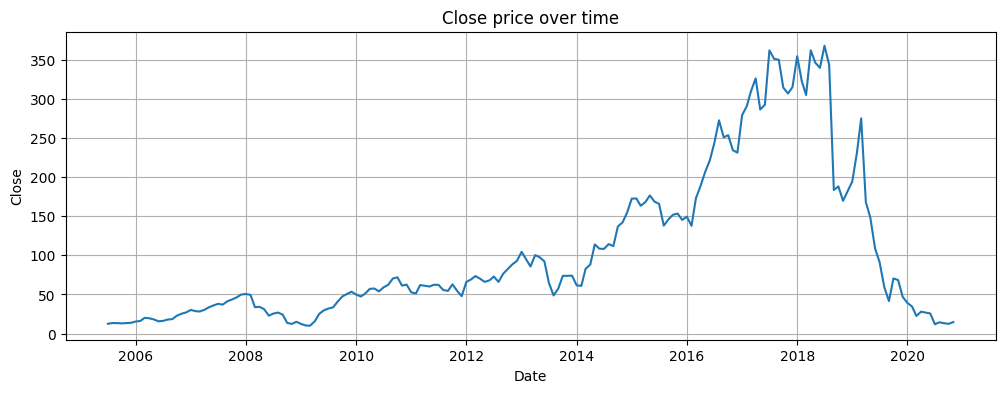

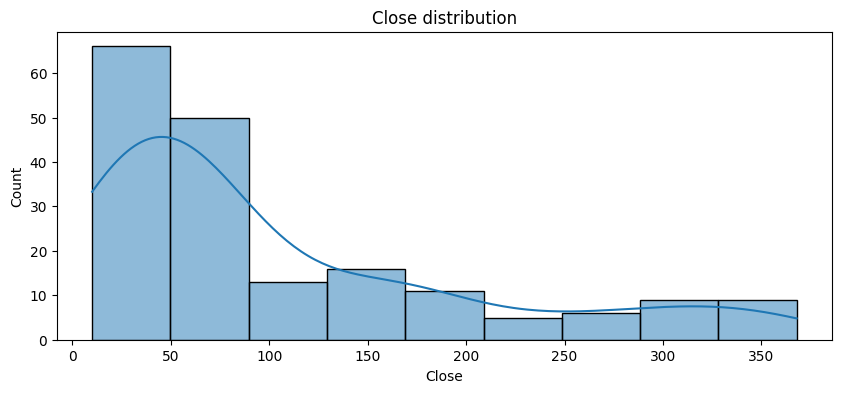

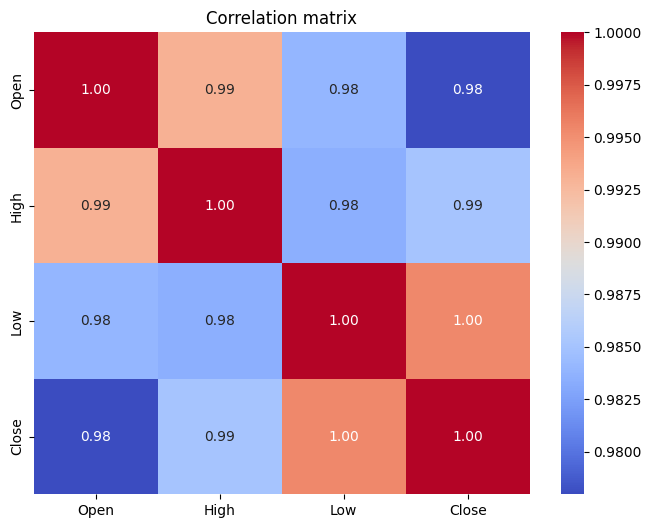


After feature creation, rows: 173
Train/Test sizes: 161 12

=== Baseline Results ===
Persistence: RMSE=8.7379, MAE=6.1642
LinearRegression: RMSE=0.0000, MAE=0.0000
RandomForest: RMSE=9.1769, MAE=6.7131


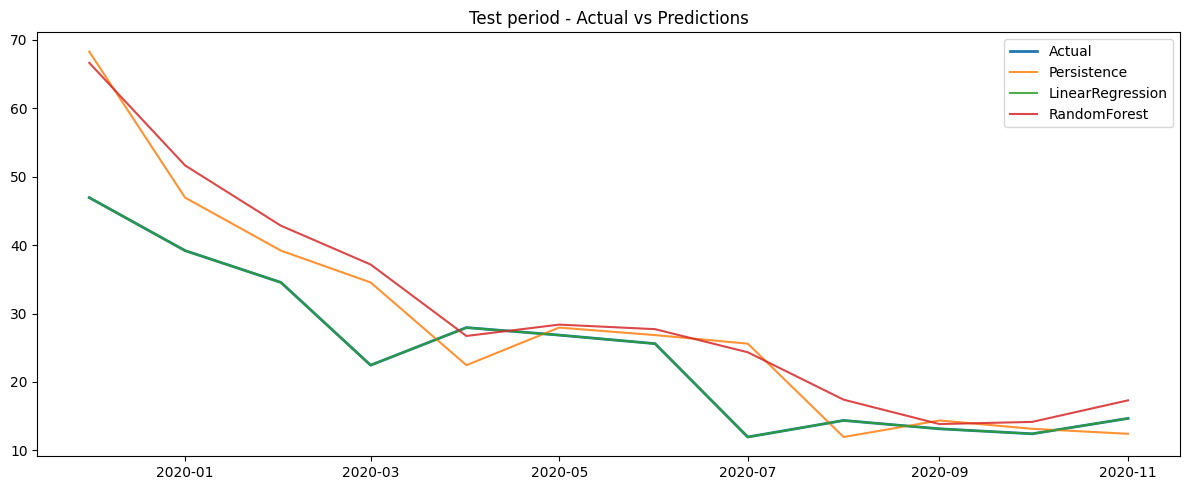

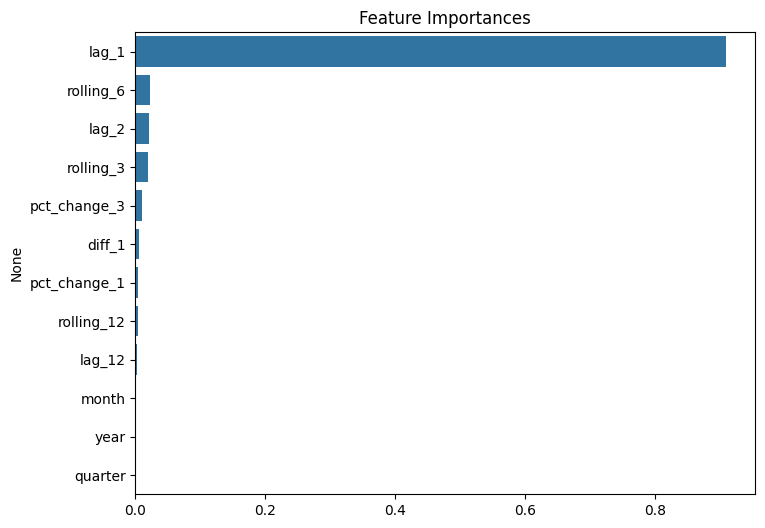


Directional accuracy for test period (without first month due to diff):
Persistence directional acc = 0.5454545454545454
LinearRegression directional acc = 1.0
RandomForest directional acc = 0.6363636363636364

=== Summary & Next steps ===
- Persistence baseline is a simple benchmark. Any model should beat it to be considered useful.
- Consider adding exogenous regressors (NIFTY/BANK index, volumes, sentiment around events).
- For event-driven structural changes (e.g., fraud) include event flags or regime-detection logic.
- Use walk-forward validation for robust evaluation and avoid data leakage.

Pipeline finished. Inspect returned `outputs` dict for further analysis.


In [ ]:
# 10. If run directly, execute pipeline with defaults
# ---------------------------
if __name__ == '__main__':
    # Default: uses file in the notebook working dir
    outputs = run_full_pipeline(path='/content/data_YesBank_StockPrices.csv', n_test=12, do_tune=False)
    print('\nPipeline finished. Inspect returned `outputs` dict for further analysis.')
